In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import tensorflow 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import image

In [2]:
# Define constants

# Define number of classes to use (this is a way to subset the data)
CLASS_NUM = 3

BATCH_SIZE = 32

In [3]:
#data preprocessing 
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge"
train_dir = base_dir + "/ILSVRC/Data/CLS-LOC/train"
subset_dir = "/kaggle/working/data"

if not os.path.exists(subset_dir):
    os.mkdir(subset_dir)
    print(subset_dir, "created!")
else:
    print(subset_dir, "already exists!")
    
# Select only first n class dirs
class_dirs = os.listdir(train_dir)[:CLASS_NUM]

# Copy class dir from train set to working dir
for class_dir in class_dirs:
    # Define current source and destination paths
    source_dir = train_dir + "/" + class_dir
    destination_dir = subset_dir + "/" + class_dir
    
    # If new class, copy to working dir
    if not os.path.exists(destination_dir):
        shutil.copytree(source_dir, destination_dir)
        print(class_dir, "succesfully copied!")
    # If it exists, don't copy again
    else:
        print(class_dir, "doesn't need copying!")

/kaggle/working/data created!
n01531178 succesfully copied!
n02412080 succesfully copied!
n02098413 succesfully copied!


In [4]:
# Import train set as a Dataset object
# (this object type can be used as input to the model)
raw_train_set = tf.keras.utils.image_dataset_from_directory(subset_dir, image_size=(224, 224))


Found 3900 files belonging to 3 classes.


model building 

In [5]:
#not normalising values as per: https://cs231n.github.io/neural-networks-2/#datapre
'''# Normalise images to [0-1] scale
train_set = raw_train_set.map(lambda x, y: (x / 255, y))'''

#function to use:
#X -= np.mean(X)

#because raw_train_set is a tf.data.dataset, need to use map 
#calculate mean across dimensions of a tensor
train_set = raw_train_set.map(lambda x, y: (x - tf.reduce_mean(x), y))


# Separate images and labels
images, labels = next(iter(train_set))

# Prepare data for training
X_train = images
y_train = pd.get_dummies(labels)



print('done')

done


Train a CNN (11 layers at first). Specifically: 
train using minibatch gradient descent (size 256), backpropagation w momentum. 
the learning rate (start at 10-2) decreased 3 times, and the learning stopped after 370K iterations (74 epochs).
L2 regularization, penalty multiplier set to 5 · 10−4 
Dropout regularization 
Weight initialization (paragraph 3.1: Training)  is random for shallow network and then weights are transferred to deeper model (LR didn’t change for transferred theta values once transferred to deeper model). 
Training image size: S =  384 and S = 256. Isotropical rescale: It means apply the same scaling factor along width and height, so the image doesn't become distorted along one axis.


docs for: 

**tf.keras.layers.Dense(**
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    ** kwargs
)

and 

**keras.layers.Conv2D** ( filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    ** kwargs

and 

**tf.keras.layers.MaxPooling2D**(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs
)

In [6]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3),padding= "same")) #conv3-64 layer 1
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding= "same")) #conv3-64 layer 2
model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 1
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding= "same")) #conv3-128 layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding= "same")) #conv3-128 layer 4
model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 2
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 5
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 6
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 7
model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 3
model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 8
model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 9
model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 10
model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 4
model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 layer 11
model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 layer 12
model.add(layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 layer 13
model.add(layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 5 - final

model.add(layers.Flatten()) #necessary for 1D Dense layer
model.add(layers.Dense(4096, activation='relu')) # FC 1 layer 9
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu')) #FC 2 layer 10
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='relu')) # FC 3 layer 11
model.add(layers.Softmax())

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [8]:
#train model 

from keras.optimizers import SGD

# Define the optimizer separately so we have better hyperparams control 
sgd = SGD(lr=0.01, momentum=0.9, weight_decay = 0.0005) #TODO: change learning rate and CHECK WEIGHT DECAU

#in 11 layer, paper initializes weights randomly
#this is redundant as this is the default initialisation method, keeping just for reference in later models w/ > layers 
weights = [np.random.rand(*w.shape) for w in model.get_weights()]
model.set_weights(weights)

# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.compile(
    optimizer=sgd,  # Optimizer
    # Loss function to minimize
    loss='categorical_crossentropy', #multinomial logistic regression
    # List of metrics to monitor
    metrics=['categorical_accuracy']
)


print("Fit model on training data")
history = model.fit(
    X_train, #X_train = images
    y_train, #pd.get_dummies(labels)
    batch_size=2, 
    #validation_split=0.15, #we might not need to do this? as this is just a test 
    epochs=2, #should be 74 
)

Fit model on training data
Epoch 1/2
16/16 [==============================] - 62s 4s/step - loss: nan - categorical_accuracy: 0.1250
Epoch 2/2
16/16 [==============================] - 58s 4s/step - loss: nan - categorical_accuracy: 0.1250


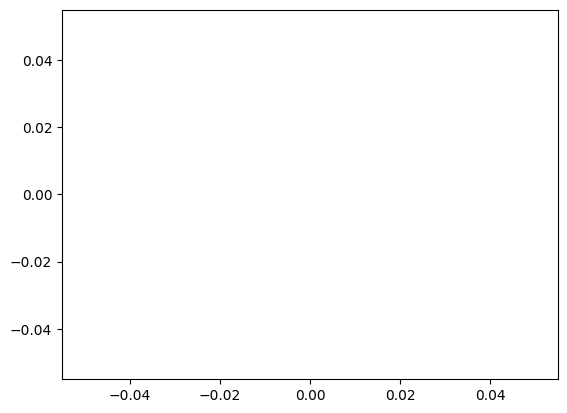

In [9]:
#The returned history object holds a record of the loss values and metric values during training:
'''history_df = pd.DataFrame(history.history)

history_df.loc[:, "loss"].plot()
'''
plt.plot(history.history['loss'])

In [10]:
#DONE: subtract the mean RGB value, computed on the training set, from each pixel
#TODO: check if need to zero gradient after update or done under hood in Tensor Flow 


#meeting 7th dec 
#add regularization in dense layers
#weight decay
#weights are initially randomized automaticamente da keras so extra one liner is non necessary for now 


#LR SHOULD DECAY PER PAPER 3 times up to 10 alla -5 

#TODO 
#regularization and weight decay austin
#checking krizhevsky austin
#image scaling Irene
#saving model in a file and transfer learning into a new file + subsetting layers Giulio 
#subtract the mean RGB value, computed on the training set, from each pixel  Irene